<a href="https://colab.research.google.com/github/Roudranil/competitions/blob/main/Kaggle/Tabular%20Playground%20Feb/tab_playground_feb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"roudranildas","key":"99cd0d0fa2839fadd6acaa8af504fcea"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle competitions download -c tabular-playground-series-feb-2021

 82% 33.0M/40.2M [00:01<00:00, 17.2MB/s]
100% 40.2M/40.2M [00:01<00:00, 36.1MB/s]
 36% 9.00M/25.1M [00:00<00:01, 16.6MB/s]
100% 25.1M/25.1M [00:00<00:00, 36.6MB/s]
  0% 0.00/470k [00:00<?, ?B/s]
100% 470k/470k [00:00<00:00, 142MB/s]


In [10]:
pip install catboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = 14, 12

In [71]:
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error as mse

In [72]:
def rmse(y1, y2):
    return np.sqrt(mse(y1, y2))

In [81]:
data = pd.read_csv('/content/train.csv.zip', index_col=0)
testdata = pd.read_csv('/content/test.csv.zip', index_col=0)
submission = pd.read_csv('/content/sample_submission.csv.zip', index_col=0)

In [26]:
data

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
id,,,,,,,,,,,,,,,,,,,,,,,,,
1,A,B,A,A,B,D,A,E,C,I,0.923191,0.684968,0.124454,0.217886,0.281421,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903,6.994023
2,B,A,A,A,B,B,A,E,A,F,0.437627,0.014213,0.357438,0.846127,0.282354,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464,8.071256
3,A,A,A,C,B,D,A,B,C,N,0.732209,0.760122,0.454644,0.812990,0.293756,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352,5.760456
4,A,A,A,C,B,D,A,E,G,K,0.705142,0.771678,0.153735,0.732893,0.769785,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766,7.806457
6,A,B,A,A,B,B,A,E,C,F,0.486063,0.639349,0.496212,0.354186,0.279105,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743,6.868974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499993,A,B,A,C,B,B,A,E,E,L,0.260716,0.712438,0.161661,0.442794,0.768447,0.269578,0.258655,0.363598,0.300619,0.340516,0.235711,0.383477,0.215227,0.793630,8.343538
499996,A,B,A,C,B,B,A,E,E,L,0.173302,0.121591,0.592514,0.193711,0.775951,0.197211,0.257024,0.574304,0.227035,0.322583,0.286094,0.324874,0.306933,0.230902,7.851861
499997,A,B,A,C,B,B,A,E,C,M,0.342856,0.617869,0.462991,0.418098,0.297406,0.449482,0.386172,0.476217,0.135947,0.502730,0.235788,0.316671,0.250286,0.349041,7.600558


In [21]:
traintest = pd.concat([data.drop(columns='target'), testdata])

-------
# EDA

1.   2 categories: 0,1,2
2.   7 categories: 8
3.   4 categories: 3,4,5
4.   8 categories: 6, 7
5.   15 categories: 9

-------

In [107]:
testdata['cat0'].value_counts()

A    187700
B     12300
Name: cat0, dtype: int64

In [108]:
data['cat0'].value_counts()

A    281471
B     18529
Name: cat0, dtype: int64

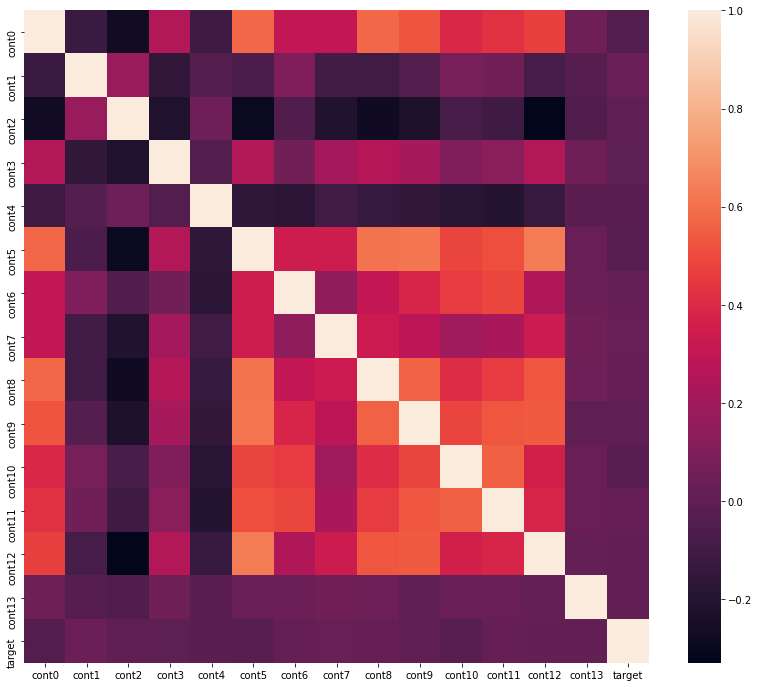

In [42]:
sns.heatmap(data.corr())

In [44]:

data.describe()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.524634,0.506649,0.444115,0.446214,0.455471,0.508337,0.478345,0.455904,0.459321,0.526899,0.504943,0.529938,0.524549,0.503349,7.456260
std,0.204875,0.235269,0.200089,0.238669,0.200695,0.231612,0.192432,0.204493,0.220642,0.204025,0.201549,0.230860,0.220892,0.225218,0.887295
min,-0.093505,-0.055105,-0.060274,0.134760,0.189216,-0.087247,0.043953,0.208703,0.004041,0.073040,0.059644,0.064161,-0.005600,0.158121,0.000000
25%,0.370451,0.352307,0.314121,0.214572,0.279853,0.338747,0.339896,0.278041,0.308655,0.361957,0.338898,0.316662,0.332143,0.291289,6.798341
50%,0.492208,0.615156,0.457271,0.377823,0.411351,0.441384,0.410090,0.360736,0.425801,0.488867,0.519855,0.558827,0.407365,0.433909,7.496503
75%,0.654793,0.688150,0.554835,0.719758,0.621808,0.709515,0.604246,0.639388,0.541525,0.752765,0.672809,0.720381,0.732431,0.730870,8.161166
max,1.052666,0.851746,1.017689,1.006469,0.994050,1.044433,1.093312,1.036541,1.014156,0.972091,1.029773,1.038049,0.961370,0.873579,10.309208


---
# some preprocessing
---

In [49]:
cat_cols = [col for col in data.columns if data[col].dtype == 'object']
num_cols = [col for col in data.columns if col not in cat_cols and col!='target']

In [45]:
from sklearn.preprocessing import StandardScaler

In [136]:
scale = StandardScaler()
train_scaled_features = pd.DataFrame(scale.fit_transform(data[num_cols]), columns=num_cols, index=data.index)
test_scaled_features = pd.DataFrame(scale.transform(testdata[num_cols]), columns=num_cols, index=testdata.index)

train = pd.concat([data.drop(columns=num_cols), train_scaled_features], axis=1)
test = pd.concat([testdata.drop(columns=num_cols), test_scaled_features], axis=1)

In [69]:
pd.Series(np.diff(train['cont2'])).value_counts()

-0.082952    2
 0.204266    2
 1.497045    1
-0.684634    1
-1.367501    1
            ..
 0.568063    1
-0.532553    1
 1.203435    1
-0.475460    1
 2.374496    1
Length: 299997, dtype: int64

In [96]:
onehot = OneHotEncoder()
label = LabelEncoder()

In [137]:
for i in range(3):
    label = LabelEncoder()
    train.iloc[:, i] = label.fit_transform(train.iloc[:, i])
    test.iloc[:, i] = label.transform(test.iloc[:, i])

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


ValueError: ignored

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,target,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
id,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,A,B,D,A,E,C,I,6.994023,1.945372,0.757938,-1.597601,-0.956673,-0.867238,1.609527,-0.294623,1.396184,1.978227,1.350628,1.088938,0.744943,1.598382,0.961533
2,1,0,0,A,B,B,A,E,A,F,8.071256,-0.424682,-2.093075,-0.433193,1.675598,-0.862591,-0.295002,-0.686557,-0.867560,0.607739,0.093896,0.537385,0.915496,-0.895782,1.354760
3,0,0,0,C,B,D,A,B,C,N,5.760456,1.013181,1.077375,0.052623,1.536759,-0.805777,1.752148,-0.565102,1.841928,1.841445,1.462334,-1.194944,0.717420,1.559967,1.443062
4,0,0,0,C,B,D,A,E,G,K,7.806457,0.881067,1.126494,-1.451257,1.201160,1.566127,1.838425,0.522703,-0.237621,1.852684,1.311128,-0.052959,0.728526,1.291356,0.494710
6,0,1,0,A,B,B,A,E,C,F,6.868974,-0.188265,0.564033,0.260374,-0.385590,-0.878778,-0.542878,1.182729,-0.639198,-0.083184,-0.317379,1.089089,0.663325,-0.819827,-0.912921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499993,0,1,0,C,B,B,A,E,E,L,8.343538,-1.288194,0.874697,-1.411648,-0.014330,1.559461,-1.030856,-1.141653,-0.451394,-0.719276,-0.913531,-1.335816,-0.634418,-1.400337,1.288893
499996,0,1,0,C,B,B,A,E,E,L,7.851861,-1.714865,-1.636671,0.741668,-1.057966,1.596853,-1.343305,-1.150129,0.578991,-1.052778,-1.001429,-1.085836,-0.888263,-0.985174,-1.209708
499997,0,1,0,C,B,B,A,E,C,M,7.600558,-0.887267,0.472735,0.094338,-0.117804,-0.787592,-0.254110,-0.478991,0.099331,-1.465608,-0.118463,-1.335434,-0.923796,-1.241619,-0.685152


In [131]:
cols = ['cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9']
y = train['target']
kf = KFold(random_state=2021, shuffle=True)
ind = kf.split(y)

for col in cols:
    for tr_ind, val_ind in ind:
        X_tr, X_val = train.iloc[tr_ind], train.iloc[val_ind]
        means+= X_tr.groupby(col)['target'].mean()
    means/=5
    train[col] = train[col].map(means)
    test[col] = test[col].map(means)
    break

In [133]:
train['cat4'].value_counts()

9.146909    297373
9.157720      1241
9.398293       767
9.116296       619
Name: cat4, dtype: int64

In [128]:
pd.Series(dict(means))

A    7.463125
B    7.455921
C    7.661192
D    7.402355
dtype: float64

In [129]:
means = means + pd.Series({'A':1, 'B':1, 'C':1, 'D':1})

In [130]:
means

cat4
A    8.463125
B    8.455921
C    8.661192
D    8.402355
dtype: float64



---
# test model


---




In [73]:
X = train.drop('target', axis=1)
y = train['target']

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size = 1/3, random_state = 1)

In [75]:
cbr1 = CatBoostRegressor()
cbr1.fit(X_tr, y_tr)
y_pred_cbr1 = cbr1.predict(X_val)

CatBoostError: ignored



---
# Submission


---




In [83]:
submission['target'] = data.target.mean()
submission.to_csv('submission1.csv')
!kaggle competitions submit -c tabular-playground-series-feb-2021 -f /content/submission1.csv -m " "

In [88]:
submission['target'] = data.target.mean() + data.target.std()
submission.to_csv('submission2.csv')
!kaggle competitions submit -c tabular-playground-series-feb-2021 -f /content/submission2.csv -m "mean+std"

100% 4.54M/4.54M [00:06<00:00, 733kB/s]
Successfully submitted to Tabular Playground Series - Feb 2021

In [89]:
submission['target'] = data.target.mean() - (data.target.std()*data.target.var())
submission.to_csv('submission3.csv')
!kaggle competitions submit -c tabular-playground-series-feb-2021 -f /content/submission3.csv -m "mean-(std*var)"

100% 4.73M/4.73M [00:04<00:00, 1.20MB/s]
Successfully submitted to Tabular Playground Series - Feb 2021

In [94]:
submission['target'] = 7.4
submission.to_csv('submission4.csv')
!kaggle competitions submit -c tabular-playground-series-feb-2021 -f /content/submission4.csv -m "7.4"

100% 2.06M/2.06M [00:05<00:00, 366kB/s]
Successfully submitted to Tabular Playground Series - Feb 2021

In [95]:
submission['target'] = 7.5
submission.to_csv('submission5.csv')
!kaggle competitions submit -c tabular-playground-series-feb-2021 -f /content/submission5.csv -m "7.5"

100% 2.06M/2.06M [00:03<00:00, 602kB/s]
Successfully submitted to Tabular Playground Series - Feb 2021